Aperture as a thermal plate
====
Last updated: 27 Aug 2018  
  
This is a heat transfer analysis of the heat generated by the amplifiers used in the RF front end section of the CBITS phased array.  The amplifiers generate about 0.35 Watts of heat each and 11,824 are used in the RF front end circuits.  The heat from these components must be transferred out to the environment.  This analysis will calculate the surface temperature of the antenna board.  
  
This analysis treats the amplifier board as a vertical plate with an internal source of heat.  Convection and radiation heat transfer are included.  Equations and methods follow the examples in Heat Transfer, A Practical Approach, 2nd Edition, by Yunus A. Cengel.  

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Power dissipated by front end RF amps

In [2]:
# L and S band amplifier is a TQP3M9037
Vdd = 5  # volts
Idd = 0.07  # 70mA typical
pwr_TQP3M9037 = Vdd*Idd
print('power dissipated by each TQP3M9037 = {:.2f} W'.format(pwr_TQP3M9037))

# L-Band
num_ele = 140
amps_per_ele = 4
pwr_L_band_rf_amps = num_ele*amps_per_ele*pwr_TQP3M9037
print('L-Band: power used by RF front end amps = {:.1f} W'.format(pwr_L_band_rf_amps))

# S-Band
num_ele = 512
amps_per_ele = 4
pwr_S_band_rf_amps = num_ele*amps_per_ele*pwr_TQP3M9037
print('S-Band: power used by RF front end amps = {:.1f} W'.format(pwr_S_band_rf_amps))
print()

# C-Band, amp is a QPL9503, Vdd=5V, Idd=56mA
num_ele = 1536
amps_per_ele = 6
Vdd = 5  # volts
Idd = 0.056  # 56mA typical
pwr_TQP3M9503 = Vdd*Idd
print('power dissapated by each QPL9503 = {:.2f} W'.format(pwr_TQP3M9503))
pwr_C_band_rf_amps = num_ele*amps_per_ele*pwr_TQP3M9503
print('C-Band: power used by RF front end amps = {:.1f} W'.format(pwr_C_band_rf_amps))

total_pwr_rf_amps = pwr_L_band_rf_amps + pwr_S_band_rf_amps + pwr_C_band_rf_amps
print('total power used by all front end RF amps = {:,.1f} W'.format(total_pwr_rf_amps))

power dissipated by each TQP3M9037 = 0.35 W
L-Band: power used by RF front end amps = 196.0 W
S-Band: power used by RF front end amps = 716.8 W

power dissapated by each QPL9503 = 0.28 W
C-Band: power used by RF front end amps = 2580.5 W
total power used by all front end RF amps = 3,493.3 W


# Vertical plate with convection and radiation heat transfer at 1 atmosphere
Each antenna aperture is modeled as a vertical plate with convection and radiation as the heat transfer mechanisms.  The amplifier board is assumed to be internal to the antenna panel assembly. Convection currents from one panel to the next are probably limited by the mechanical structure.  Never the less, the heat needs to go somewhere.  The calculated surface temperature of the plate is the midpoint, with higher temperatures at the top of the aperture.  

In [3]:
# size of individual apertures, aperture size info is from WG-1 rev 2 slide #168...
L_band_aperture = 3340.9*0.00064516
print('area of L-Band aperture = {:,.3f} m^2'.format(L_band_aperture))
S_band_aperture = 4942.1*0.00064516
print('area of S-Band aperture = {:,.3f} m^2'.format(S_band_aperture))
C_band_aperture = 3302.4*0.00064516
print('area of C-Band aperture = {:,.3f} m^2'.format(C_band_aperture))
area = L_band_aperture+S_band_aperture+C_band_aperture
print('total area of aperture = {:,.3f} m^2'.format(area))

area of L-Band aperture = 2.155 m^2
area of S-Band aperture = 3.188 m^2
area of C-Band aperture = 2.131 m^2
total area of aperture = 7.474 m^2


### Properties of air at 1 atmosphere
Select data taken from Table A-15, page 874.

In [4]:
temp = np.array([-100,-50,-40,-30,-20,-10,0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120],dtype=float)
thermal_conduc = np.array([.01582,.01979,.02057,.02134,.02211,.02288,.02364,.02401,.02439,.02476,.02514,
    .02551,.02588,.02625,.02662,.02699,.02735,.02808,.02881,.02953,.03024,.03095,.03235])
kinem_visc = np.array([.5837,.9319,1.008,1.087,1.169,1.252,1.338,1.382,1.426,1.470,1.516,1.562,1.608,
    1.655,1.702,1.750,1.798,1.896,1.995,2.097,2.201,2.306,2.522])*1e-5
Prandle_num = np.array([.7263,.7440,.7436,.7425,.7408,.7387,.7362,.7350,.7336,.7323,.7309,.7296,.7282,
    .7268,.7255,.7241,.7228,.7202,.7177,.7154,.7132,.7111,.7073])

## L-Band

In [5]:
L = 0.0254*60 # length, use L as the characteristic dimension
As = L_band_aperture*2  # surface area, use both sides
Tinf = 20  # temperature of air far away
Ts = 26.45 # initial guess

# air at film temperature
Tf = (Ts+Tinf)/2

# calculate Grashof number
v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air at 1 atm, see table A-15
g = 9.81 # gravitational acceleration, m/s^2
B = 1/(Tf+273) # coefficient of volume expansion, 1/K (B = 1/T for ideal gases)
Gr = (g*B*(Ts-Tinf)*L**3)/v**2
print('Grashof number = {:.3e}'.format(Gr))

Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, see table A-15
Ra = Gr*Pr
print('Rayleigh number = {:.3e}'.format(Ra))

# use the complex expression for vertical plate
Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2
print('Nusselt number = {:.1f}'.format(Nu))

k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
h = (k/L)*Nu
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))

Q_tot = pwr_L_band_rf_amps # power dissapated by the RF amps

# radiation heat transfer
em = 0.8  # emissivity of the board
sigma = 5.67e-8  # Stefan-Boltzmann constant
Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
print('radiation heat transfer = {:.2f} W'.format(Q_rad))

Q_conv = Q_tot - Q_rad
print('convective heat transfer = {:.2f} W'.format(Q_conv))
# re-arranging Q = h*As*(Ts-Tinf)
Ts = Q_conv/(h*As) + Tinf
print('surface temperature = {:.2f} C'.format(Ts))

Grashof number = 3.047e+09
Rayleigh number = 2.222e+09
Nusselt number = 157.9
convective heat transfer coefficient of the flow = 2.655
radiation heat transfer = 131.15 W
convective heat transfer = 64.85 W
surface temperature = 25.67 C


The python code above is converted into a function so that fsolve can be used to iterate a solution to the surface temperature.

In [6]:
def L_plate_sea_level(Ts):
    L = 0.0254*60 # length, use L as the characteristic dimension
    As = L_band_aperture*2  # surface area, use both side
    Tinf = T_test # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_L_band_rf_amps # power dissapated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [7]:
T_x = np.arange(-55, 90, 5)
T_y = np.zeros(len(T_x))  # temperature, units of degrees C
for i in range(len(T_x)):
    Ts = 20
    T_test = T_x[i]
    T_y[i] = float(fsolve(L_plate_sea_level,T_x[i]+10))

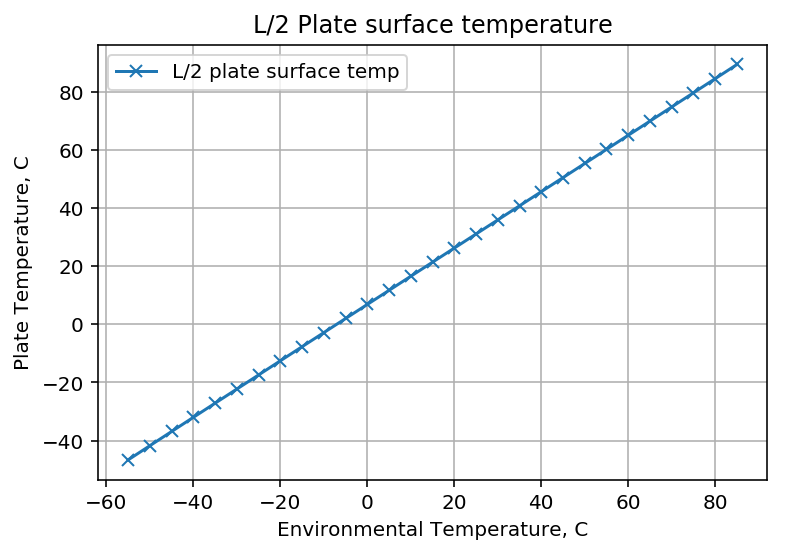

In [8]:
# plate surface temperature vs ambient temperature
plt.plot(T_x,T_y,'-x',label='L/2 plate surface temp')
plt.xlabel('Environmental Temperature, C')
plt.ylabel('Plate Temperature, C')
plt.title('L/2 Plate surface temperature')
plt.legend()
plt.grid()
plt.show()

## S-Band

In [9]:
def S_plate_sea_level(Ts):
    L = 0.0254*60 # length, use L as the characteristic dimension
    As = S_band_aperture*2  # surface area, use both side
    Tinf = T_test # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_S_band_rf_amps # power dissapated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [10]:
T_x = np.arange(-55, 90, 5)
T_y = np.zeros(len(T_x))  # temperature, units of degrees C
for i in range(len(T_x)):
    Ts = 20
    T_test = T_x[i]
    T_y[i] = float(fsolve(S_plate_sea_level,T_x[i]+10))

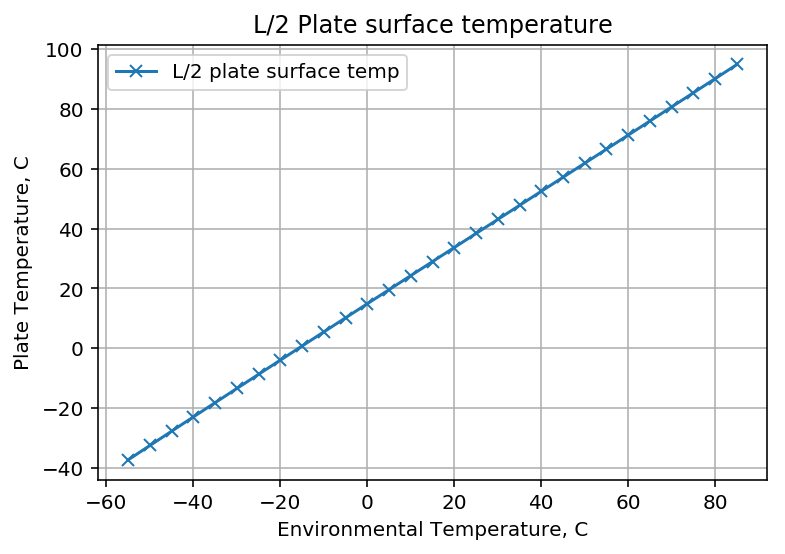

In [11]:
# plate surface temperature vs ambient temperature
plt.plot(T_x,T_y,'-x',label='L/2 plate surface temp')
plt.xlabel('Environmental Temperature, C')
plt.ylabel('Plate Temperature, C')
plt.title('L/2 Plate surface temperature')
plt.legend()
plt.grid()
plt.show()

## C-Band

In [12]:
def C_plate_sea_level(Ts):
    L = 0.0254*60 # length, use L as the characteristic dimension
    As = C_band_aperture*2  # surface area, use both side
    Tinf = T_test # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_C_band_rf_amps # power dissapated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [13]:
T_x = np.arange(-55, 90, 5)
T_y = np.zeros(len(T_x))  # temperature, units of degrees C
for i in range(len(T_x)):
    Ts = 20
    T_test = T_x[i]
    T_y[i] = float(fsolve(C_plate_sea_level,T_x[i]+10))

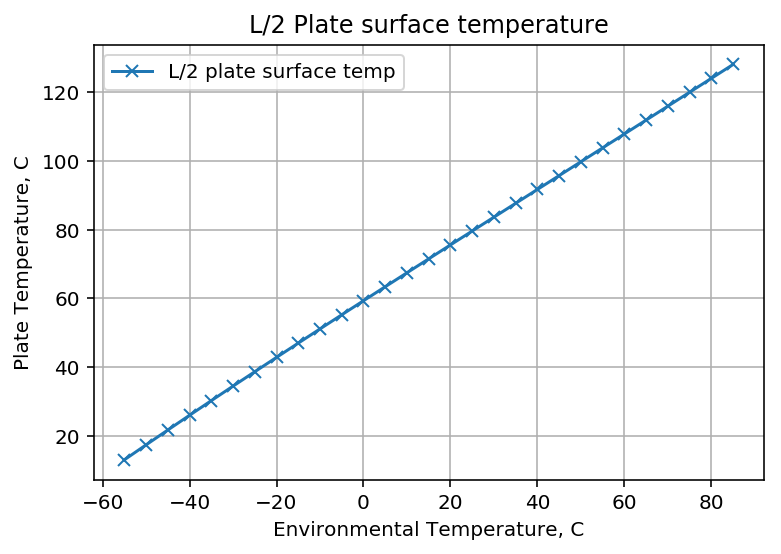

In [14]:
# plate surface temperature vs ambient temperature
plt.plot(T_x,T_y,'-x',label='L/2 plate surface temp')
plt.xlabel('Environmental Temperature, C')
plt.ylabel('Plate Temperature, C')
plt.title('L/2 Plate surface temperature')
plt.legend()
plt.grid()
plt.show()

In [15]:
print('maximum plate temp at L/2 = {:.1f} C'.format(T_y.max()))

maximum plate temp at L/2 = 128.0 C


The QPL9503 has a maximum recommended case operating temperature = 105C, the maximum recommended junction operating temperature = 190C. The plot above shows the max temperature = 128C at the L/2 point on the plate.  

In [16]:
# junction temperature
theta = 48  # thermal resistance channel to case C/W, from datasheet
T_junction = pwr_TQP3M9503*theta + T_y.max()
print('junction temperature = {:.1f} C'.format(T_junction))

junction temperature = 141.5 C


## C-Band LRU antenna panel
There are 24 C-Band LRU panels in the array and 64 elements per LRU.  The following analysis will look at on LRU over the qual temperture range of -55 to 85C for externally mounted equipment.  

In [17]:
# estimate dimensions of the C-Band LRU
C_band_LRU_area = C_band_aperture/24  # total C-Band aperture divided by 24
print('area of C-Band LRU = {:,.3f} m^2'.format(C_band_LRU_area))
C_band_LRU_length = 0.0254*60/4  # there are 4 panels stacked vertically
print('C-Band LRU length = {:,.3f} m'.format(C_band_LRU_length))

# C-Band, amp is a QPL9503, Vdd=5V, Idd=56mA
num_ele = 64  # 64 elements per LRU, 8x8
amps_per_ele = 6
Vdd = 5  # volts
Idd = 0.056  # 56mA typical
pwr_TQP3M9503 = Vdd*Idd
print('power dissapated by each QPL9503 = {:.2f} W'.format(pwr_TQP3M9503))
pwr_C_band_LRU = num_ele*amps_per_ele*pwr_TQP3M9503
print('C-Band LRU: power used by RF front end amps = {:.1f} W'.format(pwr_C_band_LRU))

area of C-Band LRU = 0.089 m^2
C-Band LRU length = 0.381 m
power dissapated by each QPL9503 = 0.28 W
C-Band LRU: power used by RF front end amps = 107.5 W


In [18]:
# calculate the surface temperature on the LRU mounted vertical
def C_LRU_sea_level(Ts):
    L = C_band_LRU_length # length, use L as the characteristic dimension
    As = C_band_LRU_area*2  # surface area, use both side
    Tinf = T_test # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    v = np.interp(Ts,temp,kinem_visc)  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_C_band_LRU # power dissapated by the RF amps in the LRU

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [19]:
T_x = np.arange(-55, 90, 5)
T_y = np.zeros(len(T_x))  # temperature, units of degrees C
for i in range(len(T_x)):
    Ts = 20
    T_test = T_x[i]
    T_y[i] = float(fsolve(C_LRU_sea_level,T_x[i]+10))

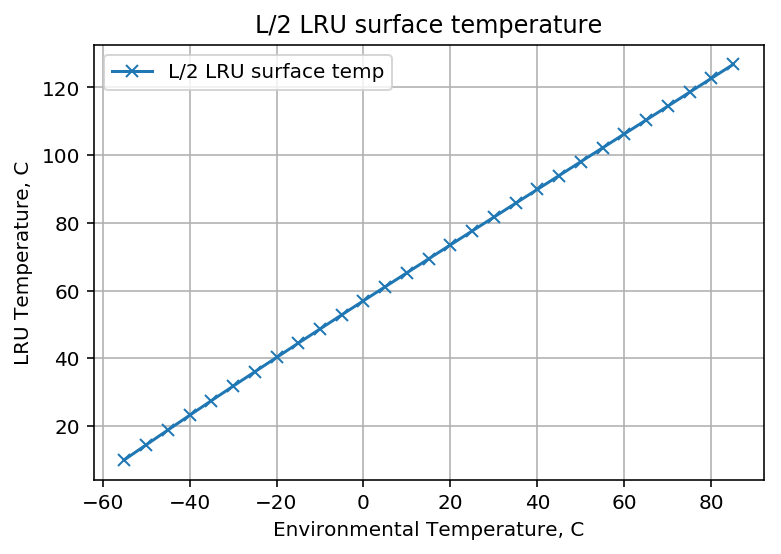

In [20]:
# LRU surface temperature vs ambient temperature
plt.plot(T_x,T_y,'-x',label='L/2 LRU surface temp')
plt.xlabel('Environmental Temperature, C')
plt.ylabel('LRU Temperature, C')
plt.title('L/2 LRU surface temperature')
plt.legend()
plt.grid()
plt.show()

In [21]:
print('maximum LRU temp at L/2 = {:.1f} C'.format(T_y.max()))

maximum LRU temp at L/2 = 126.8 C


In [22]:
# junction temperature
theta = 48  # thermal resistance channel to case C/W, from datasheet
T_junction = pwr_TQP3M9503*theta + T_y.max()
print('junction temperature = {:.1f} C'.format(T_junction))

junction temperature = 140.2 C


# Vertical plate with convection and radiation heat transfer vs altitude
These properties of air are scaled with altitude.  
v' = v/Pressure  
k' = k x Pressure  
  
Altitudes of interest is 0 to 45kft (13716 m).  

In [23]:
alt = np.linspace(0, 50000, num=30, endpoint=True)
T = np.zeros(len(alt))  # temperature, units of degrees C
rho = np.zeros(len(alt))   # pressure as a function of temperature, units of kPa

# calculate the pressure and temperature as a function of altitude
for i in range(len(alt)):
    if alt[i] <= 11000:  # The troposphere runs from the surface of the Earth to 11,000 meters.
        T[i] =  15.04 - .00649 * alt[i]
        rho[i] = 101.29 * ((T[i] + 273.1)/288.08)**5.256
    if (alt[i] > 11000) and (alt[i] <= 25000): #The lower stratosphere runs from 11,000 meters to 25,000 meters
        T[i] = -56.46  # a constant
        rho[i] = 22.65 * np.exp(1.73 - .000157 * alt[i])
    if alt[i] > 25000:  # The upper stratosphere model is used for altitudes above 25,000 meters.
        T[i] = -131.21 + 0.00299 * alt[i]
        rho[i] = 2.488 * ((T[i] + 273.1)/ 216.6)**-11.388

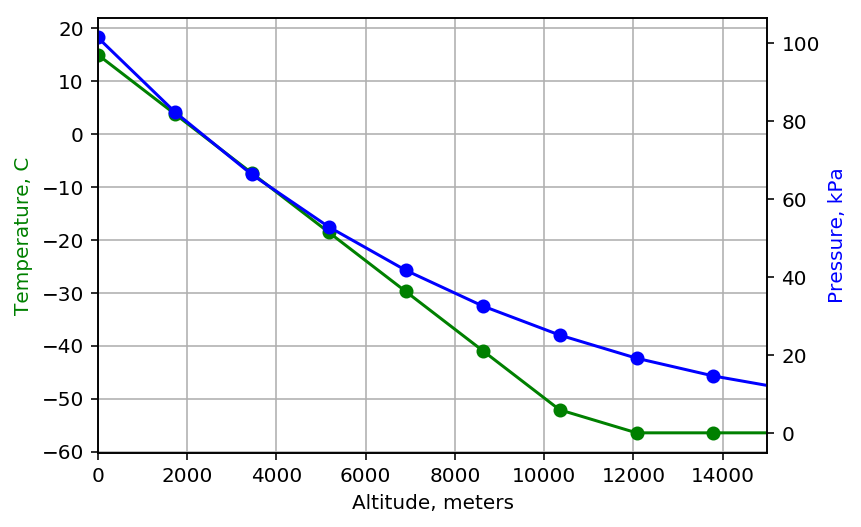

In [24]:
# plot the temperature and pressure vs altitude
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(alt, T,'g-o')
ax2.plot(alt, rho,'b-o')
ax1.set_xlabel('Altitude, meters')
ax1.set_ylabel('Temperature, C', color='g')
ax2.set_ylabel('Pressure, kPa', color='b')
ax1.grid()  # put grid marks on temperature axis
plt.xlim(0,15000)
plt.show()

## L-Band

In [25]:
elevation = 0

L = 0.0254*60 # length, use L as the characteristic dimension
As = L_band_aperture*2  # surface area, use both sides
Tinf = np.interp(elevation,alt,T) # temperature of air far away
print('Tinf = {:f}'.format(Tinf))
Ts = 21.66 # initial guess

# air at film temperature
Tf = (Ts+Tinf)/2

# calculate Grashof number
atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
print('atm = {:.3f}'.format(atm))
v = np.interp(Ts,temp,kinem_visc)/atm  # kinematic viscosity air scaled for elevation
print('kinematic viscosity = {:.3e}'.format(v))

g = 9.81 # gravitational acceleration, m/s^2
B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
Gr = (g*B*(Ts-Tinf)*L**3)/v**2
print('Grashof number = {:.3e}'.format(Gr))

Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, see table A-15
Ra = Gr*Pr
print('Rayliegh number = {:.3e}'.format(Ra))

# use the complex expression for vertical plate
Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2
print('Nusselt number = {:.1f}'.format(Nu))

k = np.interp(Ts,temp,thermal_conduc) # thermal conductivity of air, see table A-15
h = (k/L)*Nu
print('convective heat transfer coefficient of the flow = {:.3f}'.format(h))

Q_tot = pwr_L_band_rf_amps # power dissapated by the RF amps

# radiation heat transfer
em = .8  # emissivity of the board
sigma = 5.67e-8  # Stefan-Boltzmann constant
Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
print('radiation heat transfer = {:.2f} W'.format(Q_rad))

Q_conv = Q_tot - Q_rad
print('convective heat transfer = {:.2f} W'.format(Q_conv))
# re-arranging Q = h*As*(Ts-Tinf)
Ts = Q_conv/(h*As) + Tinf
print('surface temperature = {:.2f} C'.format(Ts))

Tinf = 15.040000
atm = 1.001
kinematic viscosity = 1.530e-05
Grashof number = 3.370e+09
Rayliegh number = 2.462e+09
Nusselt number = 163.1
convective heat transfer coefficient of the flow = 2.704
radiation heat transfer = 128.07 W
convective heat transfer = 67.93 W
surface temperature = 20.87 C


In [26]:
def L_plate(Ts):
    L = 0.0254*60 # length, use L as the characteristic dimension
    As = L_band_aperture*2  # surface area, use both side
    Tinf = np.interp(elevation,alt,T) # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
    v = np.interp(Ts,temp,kinem_visc)/atm  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc)*atm # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_L_band_rf_amps # power dissipated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [27]:
ele_x = np.arange(0, 16.1e3, 1000)
T_y = np.zeros(len(ele_x))  # temperature, units of degrees C
for i in range(len(ele_x)):
    elevation = ele_x[i]
    T_y[i] = float(fsolve(L_plate,np.interp(elevation,alt,T)+10))

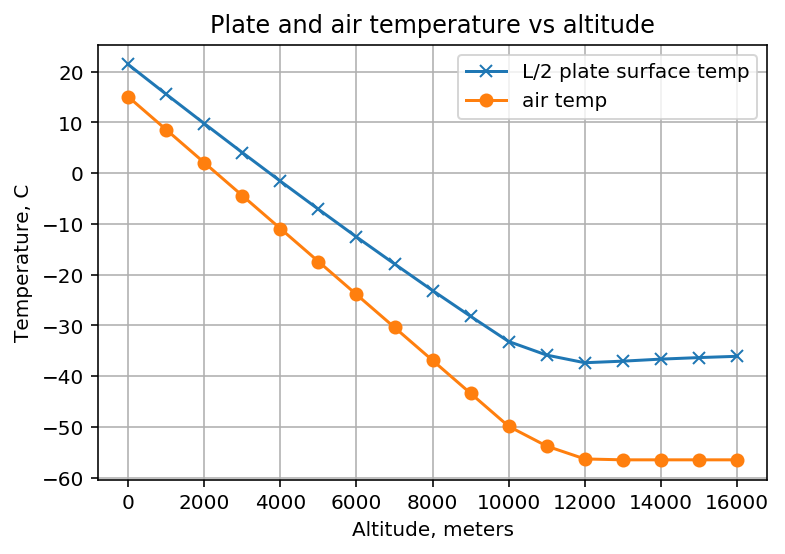

In [28]:
# plate surface temperature vs altitude
T_amb = np.interp(ele_x,alt,T) # temperature of air far away

plt.plot(ele_x,T_y,'-x',label='L/2 plate surface temp')
plt.plot(ele_x,T_amb,'-o',label='air temp')
plt.xlabel('Altitude, meters')
plt.ylabel('Temperature, C')
plt.title('Plate and air temperature vs altitude')
plt.legend()
plt.grid()
plt.show()

## S-Band

In [29]:
def S_plate(Ts):
    L = 0.0254*60 # length, use L as the characteristic dimension
    As = S_band_aperture*2  # surface area, use both side
    Tinf = np.interp(elevation,alt,T) # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
    v = np.interp(Ts,temp,kinem_visc)/atm  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc)*atm # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_S_band_rf_amps # power dissipated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [30]:
ele_x = np.arange(0, 16.1e3, 1000)
T_y = np.zeros(len(ele_x))  # temperature, units of degrees C
for i in range(len(ele_x)):
    elevation = ele_x[i]
    T_y[i] = float(fsolve(S_plate,np.interp(elevation,alt,T)+10))

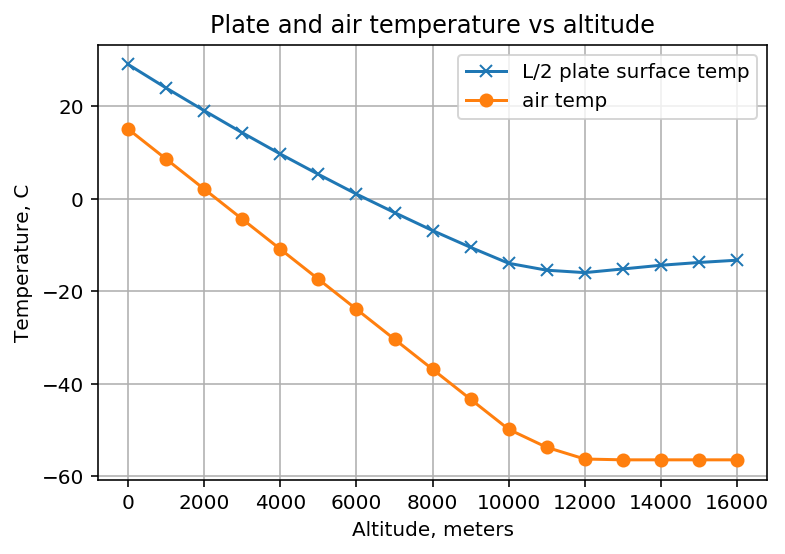

In [31]:
# plate surface temperature vs altitude
T_amb = np.interp(ele_x,alt,T) # temperature of air far away

plt.plot(ele_x,T_y,'-x',label='L/2 plate surface temp')
plt.plot(ele_x,T_amb,'-o',label='air temp')
plt.xlabel('Altitude, meters')
plt.ylabel('Temperature, C')
plt.title('Plate and air temperature vs altitude')
plt.legend()
plt.grid()
plt.show()

## C-Band

In [32]:
def C_plate(Ts):
    L = 0.0254*60 # length, use L as the characteristic dimension
    As = C_band_aperture*2  # surface area, use both side
    Tinf = np.interp(elevation,alt,T) # temperature of air far away

    # air at film temperature
    Tf = (Ts+Tinf)/2

    # calculate Grashof number
    atm = np.interp(elevation,alt,rho)*0.00986923  # convert to atm
    v = np.interp(Ts,temp,kinem_visc)/atm  # kinematic viscosity air scaled for elevation
    g = 9.81 # gravitational acceleration, m/s^2
    B = 1/(Tf+273) # coefficient of volumn expansion, 1/K (B = 1/T for ideal gases)
    Gr = (g*B*(Ts-Tinf)*L**3)/v**2

    Pr = np.interp(Ts,temp,Prandle_num)  # Prandtl number, see table A-15
    Ra = Gr*Pr

    # use the complex expression for vertical plate
    Nu = (0.825+(0.387*Ra**(1/6))/(1+(0.492/Pr)**(9/16))**(8/27))**2

    k = np.interp(Ts,temp,thermal_conduc)*atm # thermal conductivity of air, see table A-15
    h = (k/L)*Nu

    Q_tot = pwr_C_band_rf_amps # power dissipated by the RF amps

    # radiation heat transfer
    em = .8  # emissivity of the board
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    Q_rad = em*sigma*As*((Ts+273)**4-(Tinf+273)**4)
    Q_conv = Q_tot - Q_rad

    # re-arranging Q = h*As*(Ts-Tinf)
    return (Q_conv/(h*As) + Tinf) - Ts

In [33]:
ele_x = np.arange(0, 16.1e3, 1000)
T_y = np.zeros(len(ele_x))  # temperature, units of degrees C
for i in range(len(ele_x)):
    elevation = ele_x[i]
    T_y[i] = float(fsolve(C_plate,np.interp(elevation,alt,T)+10))

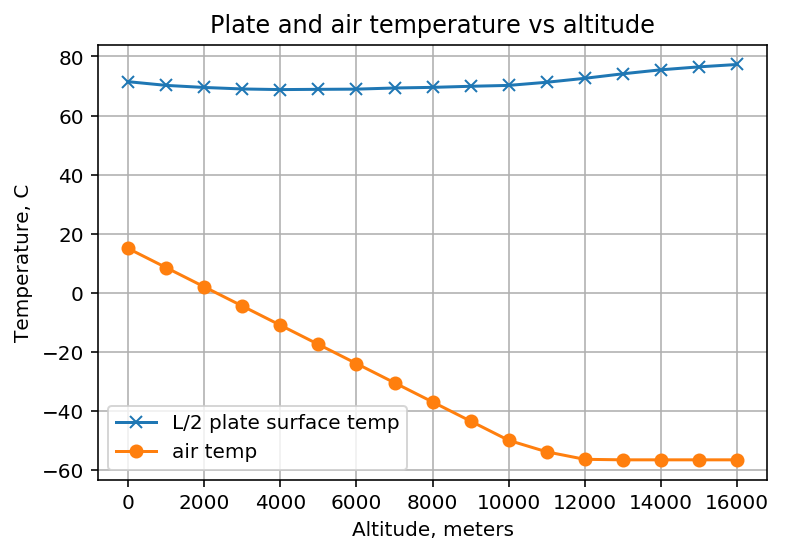

In [34]:
# plate surface temperature vs altitude
T_amb = np.interp(ele_x,alt,T) # temperature of air far away

plt.plot(ele_x,T_y,'-x',label='L/2 plate surface temp')
plt.plot(ele_x,T_amb,'-o',label='air temp')
plt.xlabel('Altitude, meters')
plt.ylabel('Temperature, C')
plt.title('Plate and air temperature vs altitude')
plt.legend()
plt.grid()
plt.show()

# Summary
C-Band RF amplifier appears to be operating beyond the maximum recommended operating temperature.  Raytheon needs to perform a detailed thermal analysis of the antenna aperture over -55 to 85 C and flight altitude.  